<a href="https://colab.research.google.com/github/y-ali0/2D-Ising-Model/blob/main/Exercise_3_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Core Task 1**

In [ ]:
''' Importing required modules '''
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

''' numpy and matplotlib.pyplot are standard modules
 numba allows parallel computing
 prange is parallel range, which allows loops to be parallelised
 njit is shorthand for @jit(nopython=True), which  compiles the code directly to machine code, bypassing the Python interpreter and hence speeding up execution of the code
 very function I define that requires optimisation using njit, I must decorate it with njit before defining it '''

' numpy and matplotlib.pyplot are standard modules\n numba allows parallel computing\n prange is parallel range, which allows loops to be parallelised\n njit is shorthand for @jit(nopython=True), which  compiles the code directly to machine code, bypassing the Python interpreter and hence speeding up execution of the code\n very function I define that requires optimisation using njit, I must decorate it with njit before defining it '

In [ ]:
@njit
def generate_spin_lattice(N, M):
    """Generate a spin lattice with dimensions N x M.

    Parameters:
    - N (int): Number of rows in the lattice.
    - M (int): Number of columns in the lattice.

    Returns:
    - numpy.ndarray: The generated spin lattice.
    """
    return np.random.choice(np.array([-1, 1], dtype=np.int8), size=(N, M))

In [ ]:
@njit
def generate_random_matrix(N, M):
    """Generate a random matrix with dimensions N x M.

    Parameters:
    - N (int): Number of rows in the matrix.
    - M (int): Number of columns in the matrix.

    Returns:
    - numpy.ndarray: The generated random matrix.
    """
    return np.random.rand(N, M)

In [ ]:
@njit(parallel=True)
def monte_carlo_step(lattice, neighbor_lattice, rand_vals, is_black, interaction_const, beta_val, beta_mu_H_val):
    """Perform a Monte Carlo step on the lattice.

    Parameters:
    - lattice (numpy.ndarray): The lattice to perform the step on.
    - neighbor_lattice (numpy.ndarray): The neighboring lattice.
    - rand_vals (numpy.ndarray): Random values used for Monte Carlo moves.
    - is_black (bool): True if the lattice is black, False otherwise.
    - interaction_const (float): J, the interaction constant
    - beta_val (float): thermodynamic beta, equal to 1/kT
    - beta_mu_H_val (float): Thermodynamic beta * magnetic moment * magnetic field

    Returns:
    - numpy.ndarray: The updated lattice after performing the step.
    """
    n, m = lattice.shape
    for i in prange(n):
        for j in prange(m):
            # Set stencil indices with periodicity
            ipp = (i + 1) if (i + 1) < n else 0
            jpp = (j + 1) if (j + 1) < m else 0
            inn = (i - 1) if (i - 1) >= 0 else (n - 1)
            jnn = (j - 1) if (j - 1) >= 0 else (m - 1)

            # Select off-column index based on color and row index parity
            if (is_black):
                joff = jpp if (i % 2) else jnn
            else:
                joff = jnn if (i % 2) else jpp

            # Compute sum of nearest neighbor spins
            nn_sum = neighbor_lattice[inn, j] + neighbor_lattice[i, j] + neighbor_lattice[ipp, j] + neighbor_lattice[i, joff]

            # Compute energy change
            spin_i = lattice[i, j]
            deltaE = -2 * spin_i * (interaction_const * nn_sum + beta_mu_H_val / beta_val)
            if deltaE > 0:
                lattice[i, j] = -spin_i
            elif rand_vals[i, j] < np.exp(deltaE * beta_val):
                lattice[i, j] = -spin_i
    return lattice

In [ ]:
@njit(parallel=True)
def merge_lattices(black_lattice, white_lattice, rows, cols):
    """Merge black and white lattices into a single lattice.

    Parameters:
    - black_lattice (numpy.ndarray): The black lattice.
    - white_lattice (numpy.ndarray): The white lattice.
    - rows (int): number of rows in the lattice
    - cols (int): number of columns in the lattice

    Returns:
    - numpy.ndarray: The merged lattice.
    """
    lattice = np.zeros((rows, cols), dtype=np.int8)
    for i in prange(rows):
        for j in prange(cols // 2):
            if (i % 2):
                lattice[i, 2 * j + 1] = black_lattice[i, j]
                lattice[i, 2 * j] = white_lattice[i, j]
            else:
                lattice[i, 2 * j] = black_lattice[i, j]
                lattice[i, 2 * j + 1] = white_lattice[i, j]
    return lattice

In [ ]:
def visualize_lattice(lattice, colorbar=True):
    """Visualize the lattice.

    Parameters:
    - lattice (numpy.ndarray): The lattice to visualize.
    - colorbar (bool): Whether to show the colorbar (default True).
    """
    plt.imshow(lattice, cmap='gray', vmin=-1, vmax=1)
    if colorbar:
        plt.colorbar()


In [ ]:
def compute_total_magnetization(lattice, rows, cols):
    """Compute the total magnetization of the lattice.

    Parameters:
    - lattice (numpy.ndarray): The lattice to compute magnetization for.
    - rows (int): The number of rows in the lattice
    - cols (int): The number of columns in the lattice

    Returns:
    - float: The total magnetization of the lattice.
    """
    return np.sum(lattice) / (rows * cols)

In [ ]:
@njit
def analytical_magnetization(T, J):
    """Calculate the analytical magnetization for an infinite lattice.

    Parameters:
    - T (float): Temperature.
    - J (float): Interaction constant.

    Returns:
    - float: Analytical magnetization.
    """
    T_c = 2 * J / (boltz_const*(np.log(1 + np.sqrt(2))))  # Critical temperature
    if T >= T_c:
        return 0
    else:
        beta = 1 / (boltz_const * T)
        return -(1 - np.sinh(2 * beta * J) ** (-4)) ** (1/8)

In [ ]:
def monte_carlo_magnetization(black_lattice, white_lattice, J, T, rows, cols, eq_steps=10000, mc_steps=100):
    """Perform Monte Carlo simulation to calculate magnetization.

    Parameters:
    - black_lattice (numpy.ndarray): The black checkerboard lattice.
    - white_lattice (numpy.ndarray): The white checkerboard lattice.
    - J (float): Interaction constant.
    - T (float): Temperature.
    - rows (int): The number of rows the total spin lattice has.
    - cols (int): The number of columns the spin lattice has.
    - eq_steps (int): Equilibration steps.
    - mc_steps (int): Monte Carlo steps.

    Returns:
    - float: Average magnetization.
    """

    magnetizations = []

    for _ in range(eq_steps):
      rand_vals = generate_random_matrix(rows, cols // 2)
      monte_carlo_step(black_lattice, white_lattice, rand_vals, True, J, 1/(boltz_const*T), 0)

      rand_vals = generate_random_matrix(rows, cols // 2)
      monte_carlo_step(white_lattice, black_lattice, rand_vals, False, J, 1/(boltz_const*T), 0)

      lattice = merge_lattices(black_lattice, white_lattice, rows, cols)

    for _ in range(mc_steps):
      rand_vals = generate_random_matrix(rows, cols // 2)
      monte_carlo_step(black_lattice, white_lattice, rand_vals, True, J, 1/(boltz_const*T), 0)

      rand_vals = generate_random_matrix(rows, cols // 2)
      monte_carlo_step(white_lattice, black_lattice, rand_vals, False, J, 1/(boltz_const*T), 0)

      lattice = merge_lattices(black_lattice, white_lattice, rows, cols)
      magnetizations.append(compute_total_magnetization(lattice,rows,cols))

    return np.mean(magnetizations)

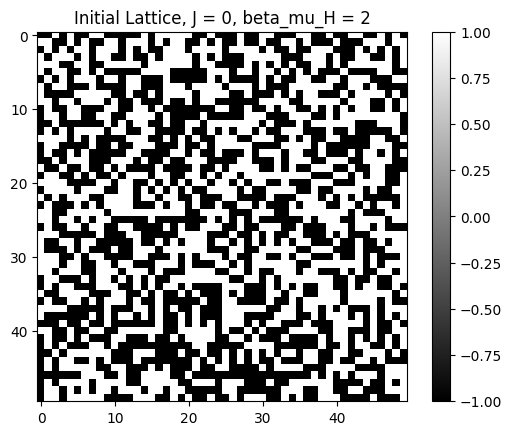

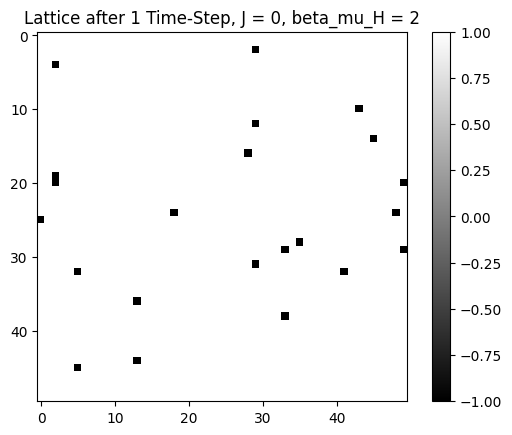

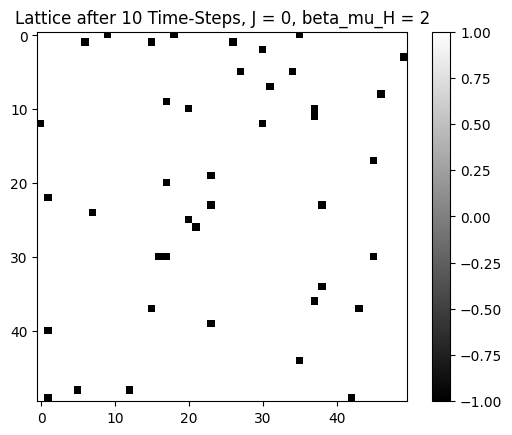

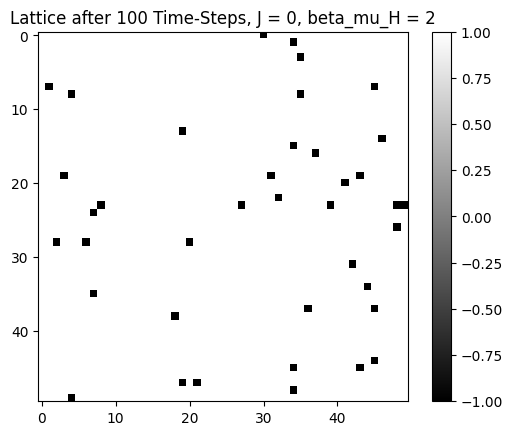

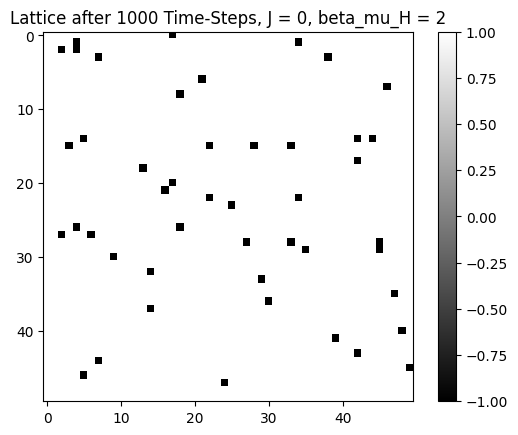

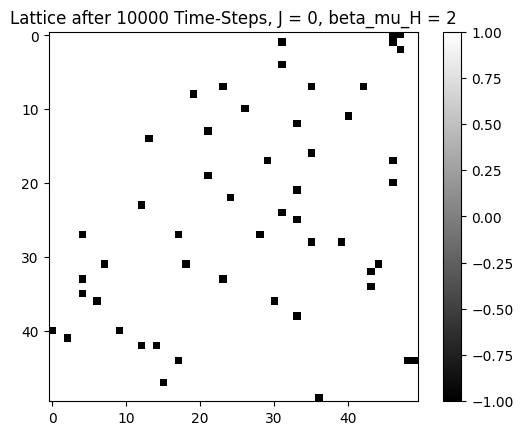

In [ ]:
# Code used to investigate the evolution of the lattice for J = 0 and beta_mu_H = 2, and plotted after 1 timestep, 10 timesteps, 100 timesteps
# 1000 timesteps, and 10000 timesteps.

# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 0  # Interaction constant
beta_mu_H_val = 2 # beta mu H
temp_val = 100 # temperature
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 50, 50).copy()  # get a snapshot of initial lattice

# Plot the initial lattice
visualize_lattice(initial_configuration)
plt.title("Initial Lattice, J = 0, beta_mu_H = 2")
plt.show()

for i in range(10000):
  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(black_lattice, white_lattice, rand_vals, True, 0, 1/(boltz_const)*1/100, 2)

  # monte_carlo_step(black_lattice, white_lattice, rand_vals, True, interaction_const, beta_val, beta_mu_H_val)

  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(white_lattice, black_lattice, rand_vals, False, 0, 1/(boltz_const)*1/100, 2)

  if i == 0:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1 Time-Step, J = 0, beta_mu_H = 2")
    plt.show()

  if i == 9:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10 Time-Steps, J = 0, beta_mu_H = 2")
    plt.show()

  if i == 99:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 100 Time-Steps, J = 0, beta_mu_H = 2")
    plt.show()

  if i == 999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1000 Time-Steps, J = 0, beta_mu_H = 2")
    plt.show()

  if i == 9999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10000 Time-Steps, J = 0, beta_mu_H = 2")
    plt.show()



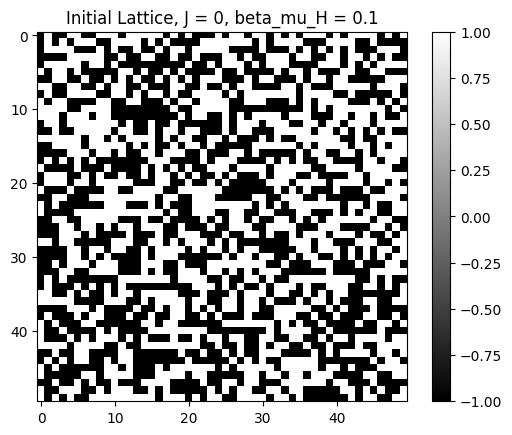

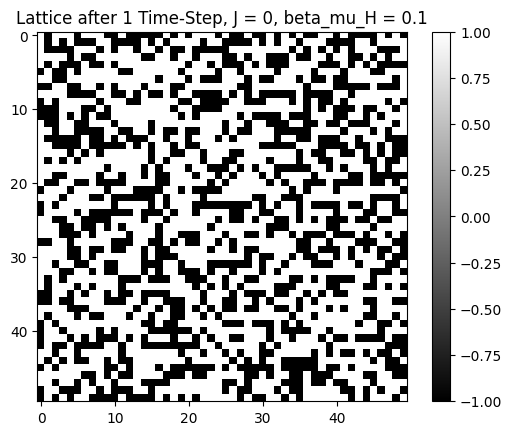

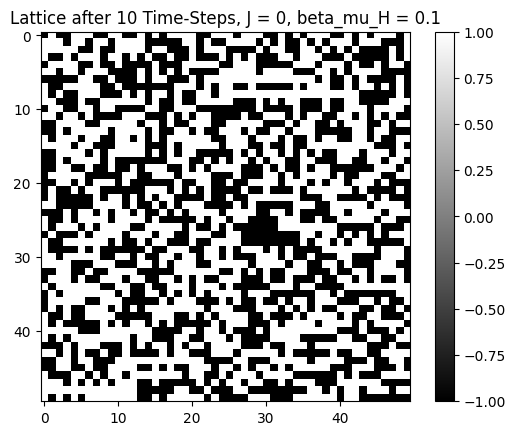

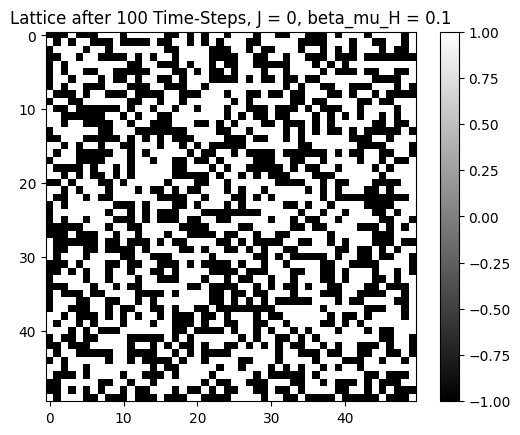

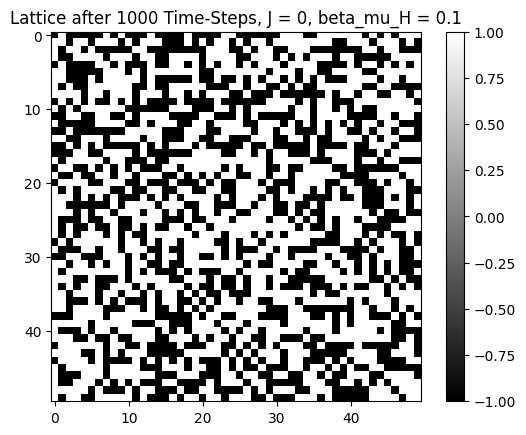

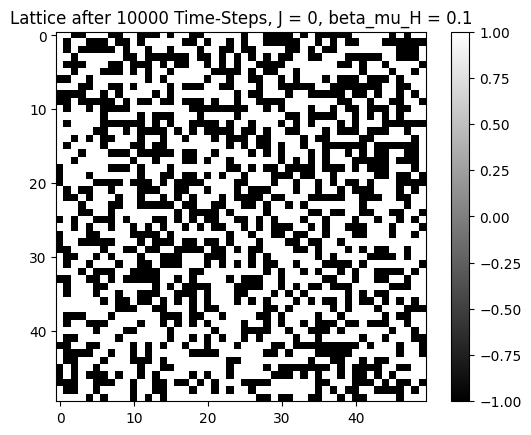

In [ ]:
# Code used to investigate the evolution of the lattice for J = 0 and beta_mu_H = 0.1, and plotted after 1 timestep, 10 timesteps, 100 timesteps
# 1000 timesteps, and 10000 timesteps.

# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 0  # Interaction constant
beta_mu_H_val = 0.1 # beta mu H
temp_val = 100
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 50, 50).copy()  # get a snapshot of initial lattice

# Plot the initial lattice
visualize_lattice(initial_configuration)
plt.title("Initial Lattice, J = 0, beta_mu_H = 0.1")
plt.show()

for i in range(10000):
  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(black_lattice, white_lattice, rand_vals, True, 0, 1/(boltz_const)*1/100, 0.1)

  # monte_carlo_step(black_lattice, white_lattice, rand_vals, True, interaction_const, beta_val, beta_mu_H_val)

  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(white_lattice, black_lattice, rand_vals, False, 0, 1/(boltz_const)*1/100, 0.1)

  if i == 0:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1 Time-Step, J = 0, beta_mu_H = 0.1")
    plt.show()

  if i == 9:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10 Time-Steps, J = 0, beta_mu_H = 0.1")
    plt.show()

  if i == 99:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 100 Time-Steps, J = 0, beta_mu_H = 0.1")
    plt.show()

  if i == 999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1000 Time-Steps, J = 0, beta_mu_H = 0.1")
    plt.show()

  if i == 9999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10000 Time-Steps, J = 0, beta_mu_H = 0.1")
    plt.show()

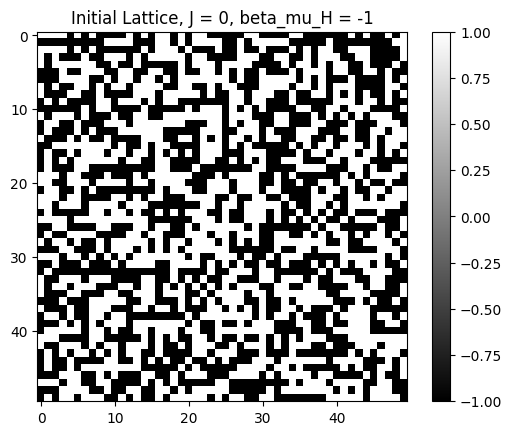

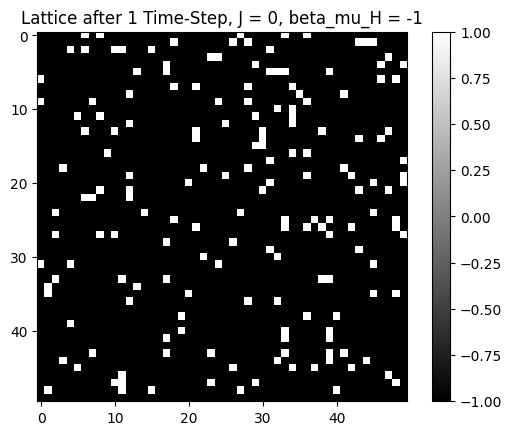

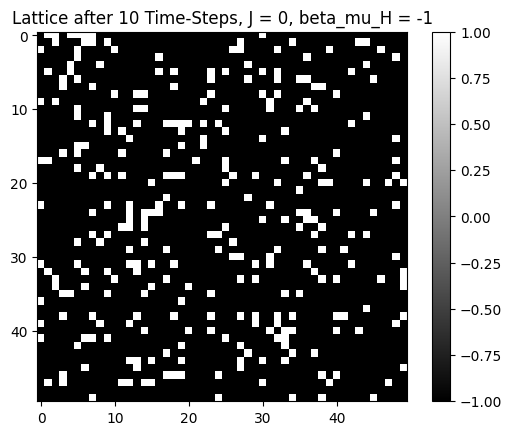

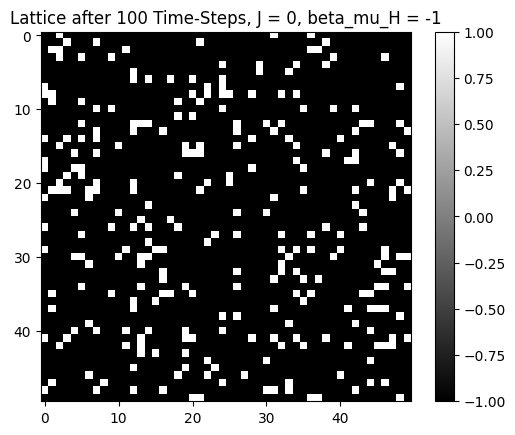

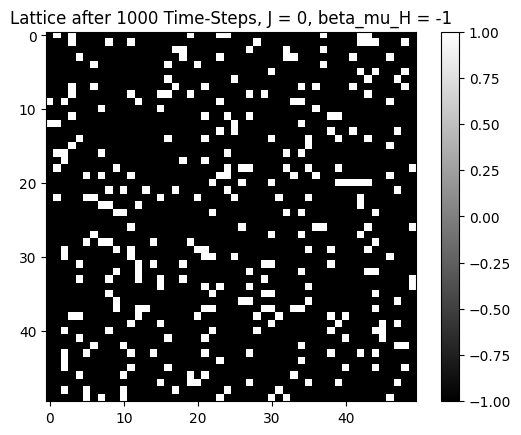

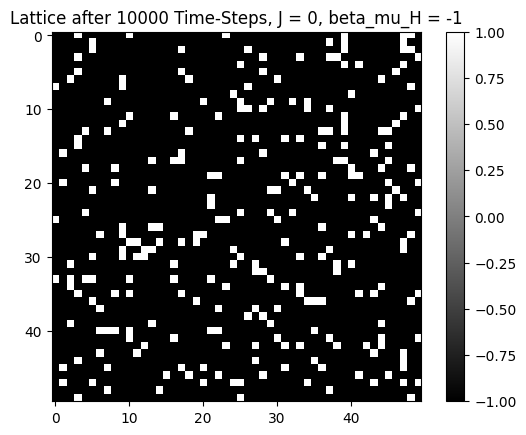

In [ ]:
# Code used to investigate the evolution of the lattice for J = 0 and beta_mu_H = -1, and plotted after 1 timestep, 10 timesteps, 100 timesteps
# 1000 timesteps, and 10000 timesteps.

# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 0  # Interaction constant
beta_mu_H_val = -1 # beta mu H
temp_val = 100
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 50, 50).copy()  # get a snapshot of initial lattice

# Plot the initial lattice
visualize_lattice(initial_configuration)
plt.title("Initial Lattice, J = 0, beta_mu_H = -1")
plt.show()

for i in range(10000):
  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(black_lattice, white_lattice, rand_vals, True, 0, 1/(boltz_const)*1/100, -1)

  # monte_carlo_step(black_lattice, white_lattice, rand_vals, True, interaction_const, beta_val, beta_mu_H_val)

  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(white_lattice, black_lattice, rand_vals, False, 0, 1/(boltz_const)*1/100, -1)

  if i == 0:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1 Time-Step, J = 0, beta_mu_H = -1")
    plt.show()

  if i == 9:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10 Time-Steps, J = 0, beta_mu_H = -1")
    plt.show()

  if i == 99:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 100 Time-Steps, J = 0, beta_mu_H = -1")
    plt.show()

  if i == 999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1000 Time-Steps, J = 0, beta_mu_H = -1")
    plt.show()

  if i == 9999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10000 Time-Steps, J = 0, beta_mu_H = -1")
    plt.show()

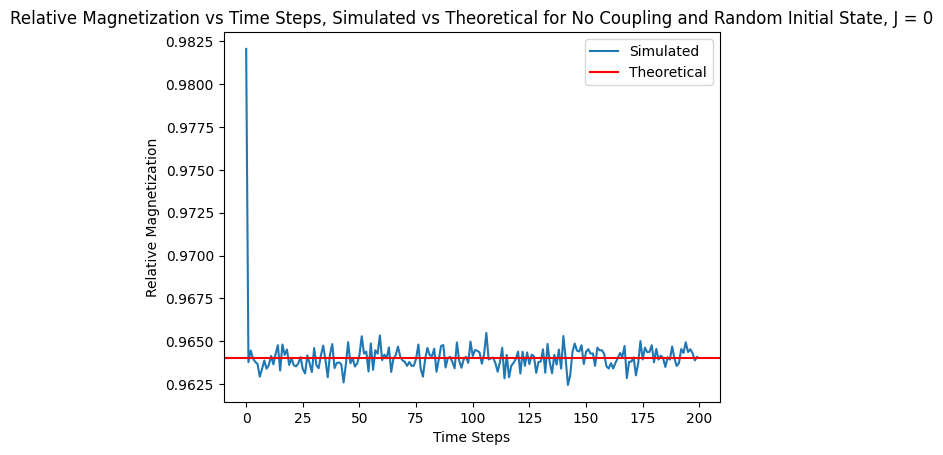

In [ ]:
# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 0  # Interaction constant
beta_mu_H_val = 2 # beta mu H
temp_val = 100
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(500, 500 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(500, 500 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 500, 500).copy()  # get a snapshot of initial lattice

# Store magnetization for each timestep

magnetizations = []

# Equilibration

for i in range(200):
    rand_vals = generate_random_matrix(500, 500 // 2)
    monte_carlo_step(black_lattice, white_lattice, rand_vals, True, 0, 1/(boltz_const*100), 2)

    rand_vals = generate_random_matrix(500, 500 // 2)
    monte_carlo_step(white_lattice, black_lattice, rand_vals, False, 0, 1/(boltz_const*100), 2)

    lattice = merge_lattices(black_lattice, white_lattice, 500, 500)
    magnetizations.append(compute_total_magnetization(lattice, 500, 500))


# Plot magnetization against time steps, compare with analytical solution

plt.plot(range(200), magnetizations, label='Simulated')
plt.xlabel('Time Steps')
plt.ylabel('Relative Magnetization')
plt.title('Relative Magnetization vs Time Steps, Simulated vs Theoretical for No Coupling and Random Initial State, J = 0')
theoretical = np.tanh(2)
# theoretical = np.tanh(beta_mu_H_val)
plt.axhline(y=theoretical, color='r', linestyle='-', label='Theoretical')
plt.legend()
plt.show()

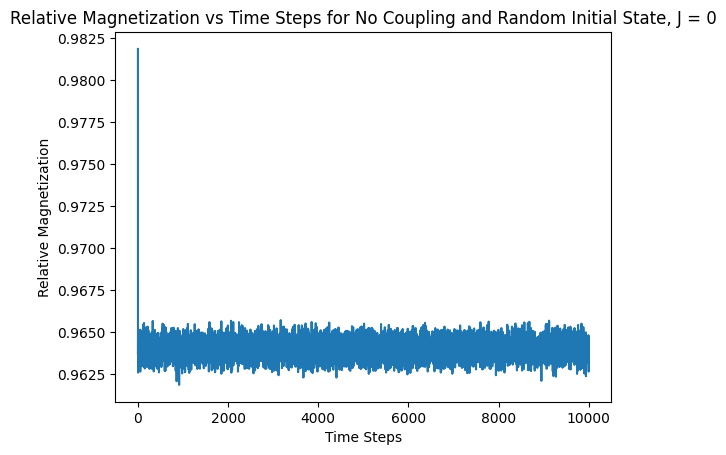

In [ ]:
# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 0  # Interaction constant
beta_mu_H_val = 2 # beta mu H
temp_val = 100
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(500, 500 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(500, 500 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 500, 500).copy()  # get a snapshot of initial lattice

# Store magnetization for each timestep

magnetizations = []

# Equilibration

for i in range(10000):
    rand_vals = generate_random_matrix(500, 500 // 2)
    monte_carlo_step(black_lattice, white_lattice, rand_vals, True, 0, 1/(boltz_const*100), 2)

    rand_vals = generate_random_matrix(500, 500 // 2)
    monte_carlo_step(white_lattice, black_lattice, rand_vals, False, 0, 1/(boltz_const*100), 2)

    lattice = merge_lattices(black_lattice, white_lattice, 500, 500)
    magnetizations.append(compute_total_magnetization(lattice, 500, 500))


# Plot magnetization against time steps

plt.plot(range(10000), magnetizations, label='Simulated')
plt.xlabel('Time Steps')
plt.ylabel('Relative Magnetization')
plt.title('Relative Magnetization vs Time Steps for No Coupling and Random Initial State, J = 0')
plt.show()

**Core Task 1: No Spin Coupling Summary**

With J = 0, we see that changing beta_mew_H effects the speed at which equilibrium is reached. The greater the beta_mew_H, the faster equilibrium (in less time-steps) is reached as well as the sign of beta_mew_H effecting whether the spins are oriented +1 or -1 in the equilibrium state. +1 if beta_mew_H is positive to minimise energy, and -1 otherwise.

The relative magnetisation, M, of the system starts off at a random value and it then quickly oscillates about and converges towards the theoretical value as the system reaches equilibrium and as the number of timesteps increases. It oscillates and if the number of timesteps tends towards infinity and the time-average is taken over the equilibrium states, then you would obtain the theoretical value given by tanh(beta_mew_H).

Hence, the Monte-Carlo method does indeed correctly reproduce the analytical formula.


**Core Task 2**

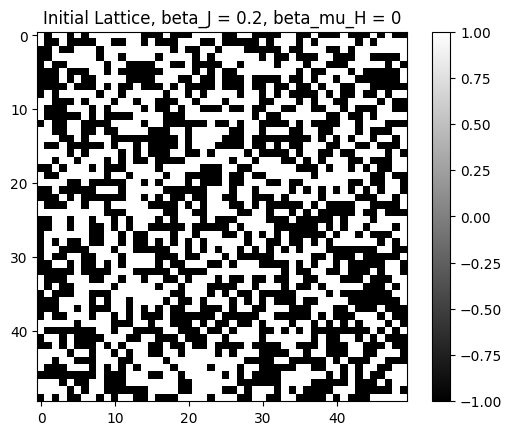

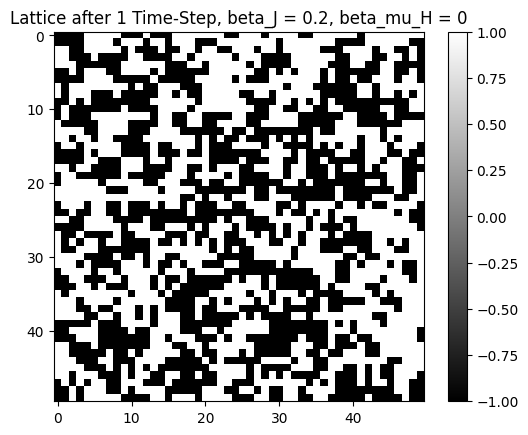

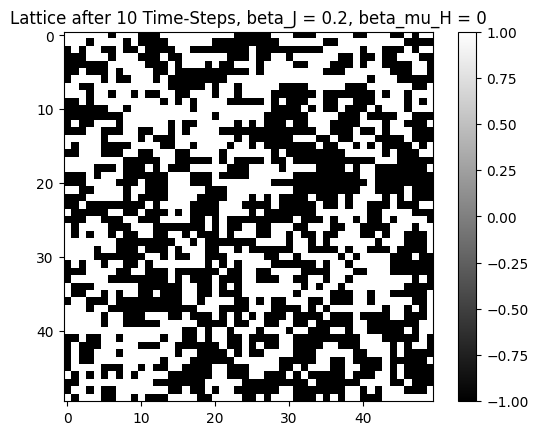

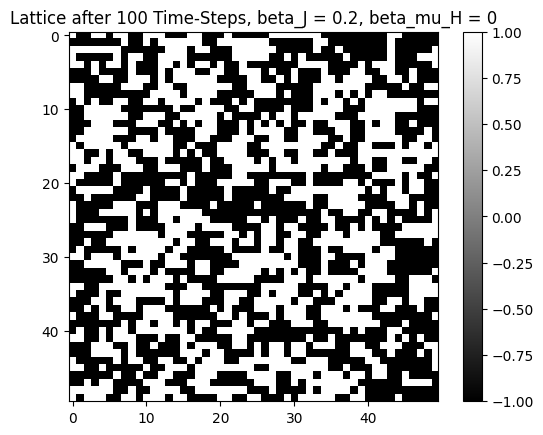

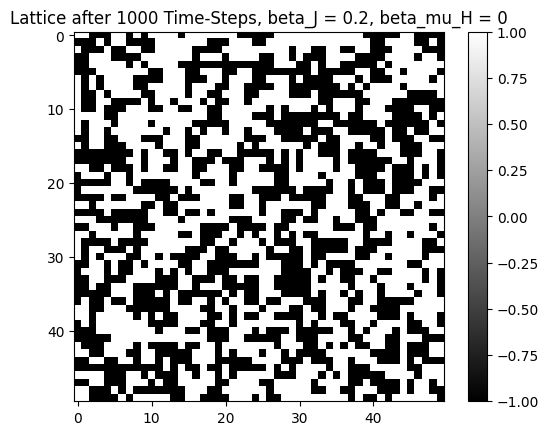

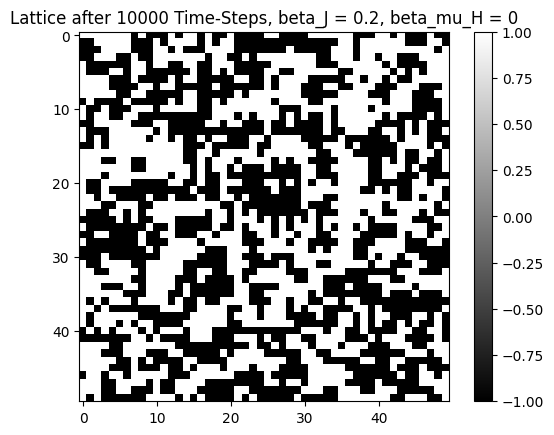

In [ ]:
# Code used to investigate the evolution of the lattice for beta_J = 0.2 and beta_mu_H = 0, and plotted after 1 timestep, 10 timesteps, 100 timesteps
# 1000 timesteps, and 10000 timesteps.

# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 0.2 / beta_val  # Interaction constant
beta_mu_H_val = 0 # beta mu H
temp_val = 100
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 50, 50).copy()  # get a snapshot of initial lattice

# Plot the initial lattice
visualize_lattice(initial_configuration)
plt.title("Initial Lattice, beta_J = 0.2, beta_mu_H = 0")
plt.show()

for i in range(10000):
  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(black_lattice, white_lattice, rand_vals, True, 0.2*boltz_const*100, 1/(boltz_const)*1/100, 0)

  # monte_carlo_step(black_lattice, white_lattice, rand_vals, True, interaction_const, beta_val, beta_mu_H_val)

  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(white_lattice, black_lattice, rand_vals, False, 0.2*boltz_const*100, 1/(boltz_const)*1/100, 0)

  if i == 0:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1 Time-Step, beta_J = 0.2, beta_mu_H = 0")
    plt.show()

  if i == 9:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10 Time-Steps, beta_J = 0.2, beta_mu_H = 0")
    plt.show()

  if i == 99:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 100 Time-Steps, beta_J = 0.2, beta_mu_H = 0")
    plt.show()

  if i == 999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1000 Time-Steps, beta_J = 0.2, beta_mu_H = 0")
    plt.show()

  if i == 9999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10000 Time-Steps, beta_J = 0.2, beta_mu_H = 0")
    plt.show()

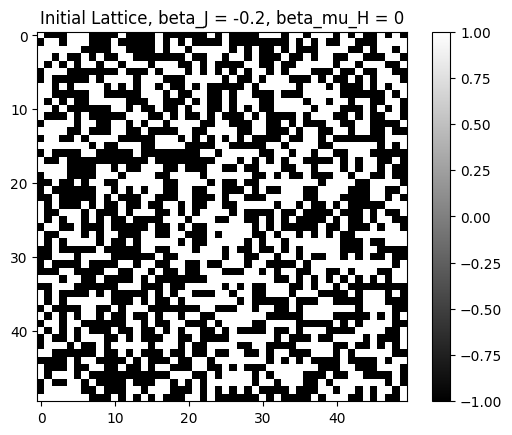

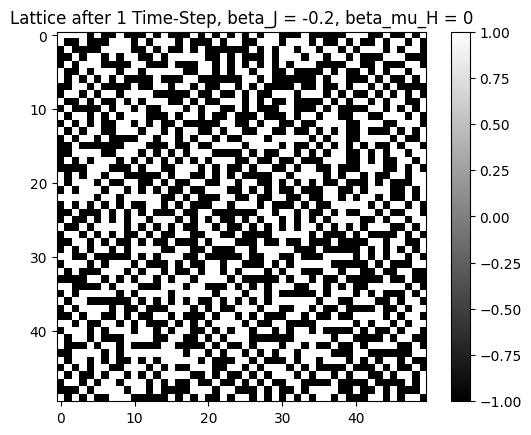

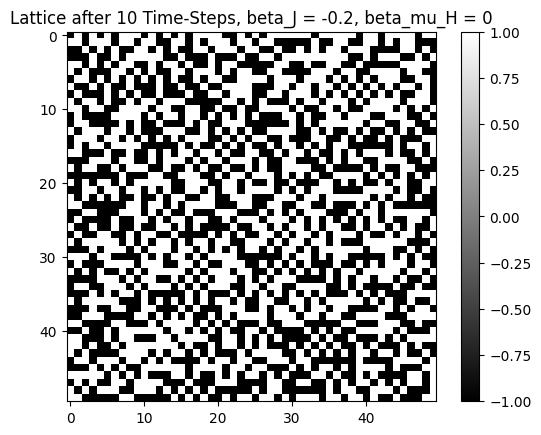

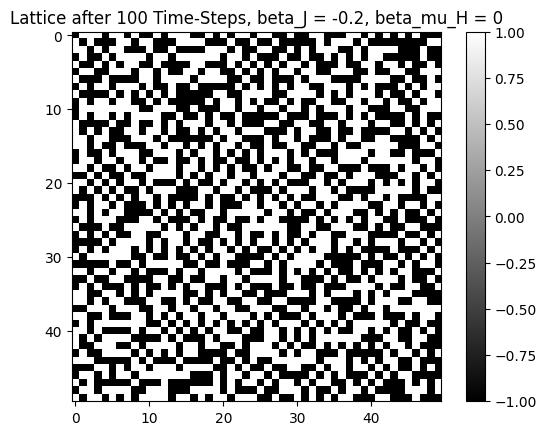

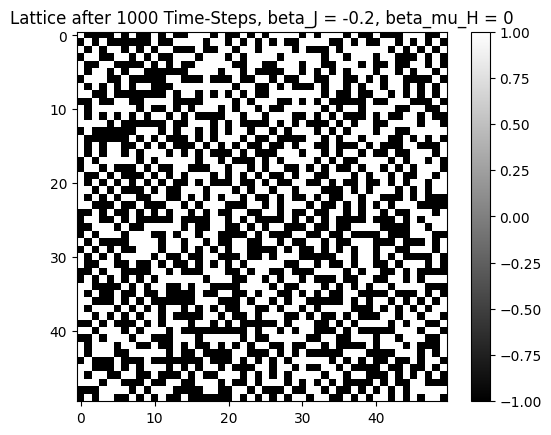

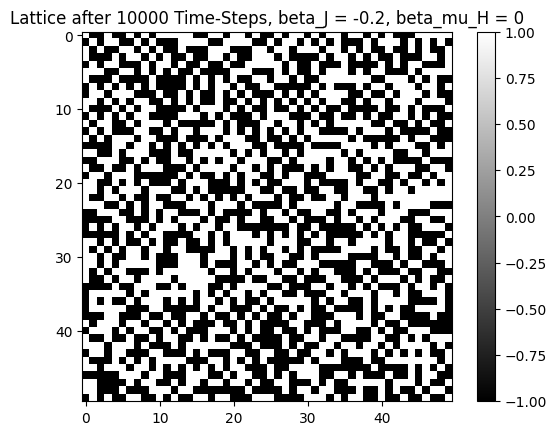

In [ ]:
# Code used to investigate the evolution of the lattice for beta_J = -0.2 and beta_mu_H = 0, and plotted after 1 timestep, 10 timesteps, 100 timesteps
# 1000 timesteps, and 10000 timesteps.

# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = -0.2 / beta_val  # Interaction constant
beta_mu_H_val = 0 # beta mu H
temp_val = 100
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 50, 50).copy()  # get a snapshot of initial lattice

# Plot the initial lattice
visualize_lattice(initial_configuration)
plt.title("Initial Lattice, beta_J = -0.2, beta_mu_H = 0")
plt.show()

for i in range(10000):
  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(black_lattice, white_lattice, rand_vals, True, -0.2*boltz_const*100, 1/(boltz_const)*1/100, 0)

  # monte_carlo_step(black_lattice, white_lattice, rand_vals, True, interaction_const, beta_val, beta_mu_H_val)

  rand_vals = generate_random_matrix(50, 50 // 2)
  monte_carlo_step(white_lattice, black_lattice, rand_vals, False, -0.2*boltz_const*100, 1/(boltz_const)*1/100, 0)

  if i == 0:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1 Time-Step, beta_J = -0.2, beta_mu_H = 0")
    plt.show()

  if i == 9:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10 Time-Steps, beta_J = -0.2, beta_mu_H = 0")
    plt.show()

  if i == 99:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 100 Time-Steps, beta_J = -0.2, beta_mu_H = 0")
    plt.show()

  if i == 999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 1000 Time-Steps, beta_J = -0.2, beta_mu_H = 0")
    plt.show()

  if i == 9999:
    lattice = merge_lattices(black_lattice, white_lattice, 50, 50).copy()
    visualize_lattice(lattice)
    plt.title("Lattice after 10000 Time-Steps, beta_J = -0.2, beta_mu_H = 0")
    plt.show()

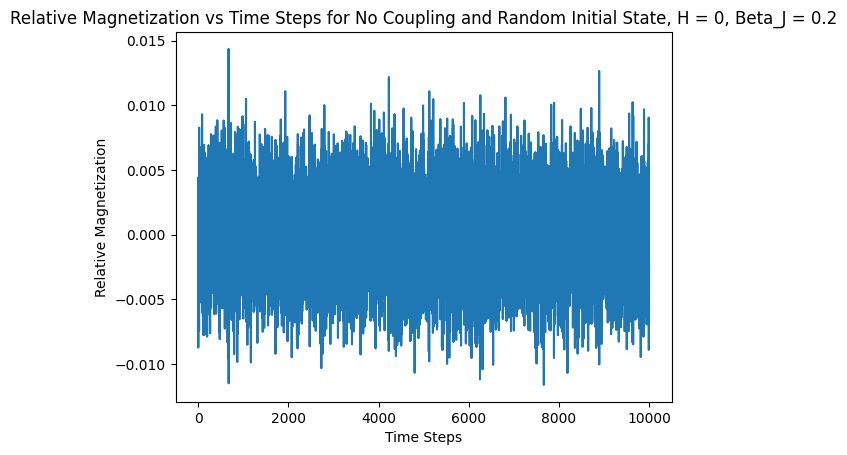

In [ ]:
# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 0.2 / beta_val  # Interaction constant
beta_mu_H_val = 0 # beta mu H
temp_val = 100
beta_val = 1 / (boltz_const * temp_val) '''

black_lattice = generate_spin_lattice(500, 500 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(500, 500 // 2)  # m/2 array for white lattice
initial_configuration = merge_lattices(black_lattice, white_lattice, 500, 500).copy()  # get a snapshot of initial lattice

# Store magnetization for each timestep

magnetizations = []

# Equilibration

for i in range(10000):
    rand_vals = generate_random_matrix(500, 500 // 2)
    monte_carlo_step(black_lattice, white_lattice, rand_vals, True, 0.2*boltz_const*100, 1/(boltz_const*100), 0)

    rand_vals = generate_random_matrix(500, 500 // 2)
    monte_carlo_step(white_lattice, black_lattice, rand_vals, False, 0.2*boltz_const*100, 1/(boltz_const*100), 0)

    lattice = merge_lattices(black_lattice, white_lattice, 500, 500)
    magnetizations.append(compute_total_magnetization(lattice, 500, 500))


# Plot magnetization against time steps

plt.plot(range(10000), magnetizations, label='Simulated')
plt.xlabel('Time Steps')
plt.ylabel('Relative Magnetization')
plt.title('Relative Magnetization vs Time Steps for No Coupling and Random Initial State, H = 0, Beta_J = 0.2')
plt.show()

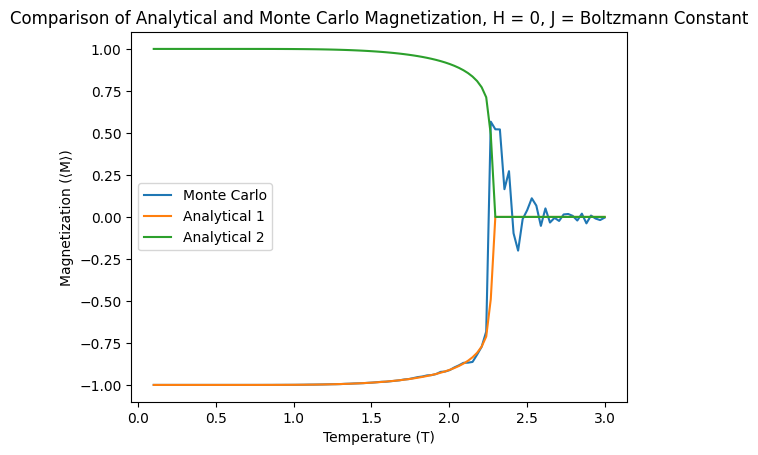

In [ ]:
# def monte_carlo_magnetization(black_lattice, white_lattice, J, T, rows, cols, eq_steps=10000, mc_steps=100)

# Boltzmann constant
boltz_const = 1.380649e-23

''' VARIABLES
interaction_const = 1 * boltz_const # Interaction constant
beta_mu_H_val = 0 # beta mu H '''

temp_values = np.linspace(0.1, 3, 100)  # temperature range

black_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for black lattice
white_lattice = generate_spin_lattice(50, 50 // 2)  # m/2 array for white lattice

analytical_results1 = []
analytical_results2 = []
monte_carlo_results = []

for temp in temp_values:
    analytical_result = analytical_magnetization(temp, boltz_const)
    monte_carlo_result = monte_carlo_magnetization(black_lattice, white_lattice, boltz_const, temp, 50, 50)
    analytical_results1.append(analytical_result)
    analytical_results2.append(-analytical_result)
    monte_carlo_results.append(monte_carlo_result)

######### PLOTTING #############
plt.plot(temp_values, monte_carlo_results, label='Monte Carlo')
plt.plot(temp_values, analytical_results1, label='Analytical 1')
plt.plot(temp_values, analytical_results2, label='Analytical 2')
plt.xlabel('Temperature (T)')
plt.ylabel('Magnetization (⟨M⟩)')
plt.title('Comparison of Analytical and Monte Carlo Magnetization, H = 0, J = Boltzmann Constant')
plt.legend()
plt.show()

**Core Task 2: only spin coupling Summary**

System behaviour when beta_J = +- 0.2 and H = 0 is very slow progression towards equilibrium. Due to energy minimisation, when J is positive we must have that neighbouring spins are aligned. Similarly, for negative J we must have antialignment of neighbouring spins. So, for the J > 0 case, after many timesteps we should see large clusters of up and down spins interposed.

The Monte Carlo method does indeed correctly reproduce the analytical formula in both regions. Sometimes, it follows the + solution in the less than T_c region, and other times the - solution in the less than T_c solution so the +- in the analytical solution is observed. The unusual behaviour we notice near the critical point, is that we have almost a step function transition, it is not smooth at all. Moreover, we notice decaying oscillations near the critical point, which then settle down into a flat line like the analytical solution.

**Supplementary Task**

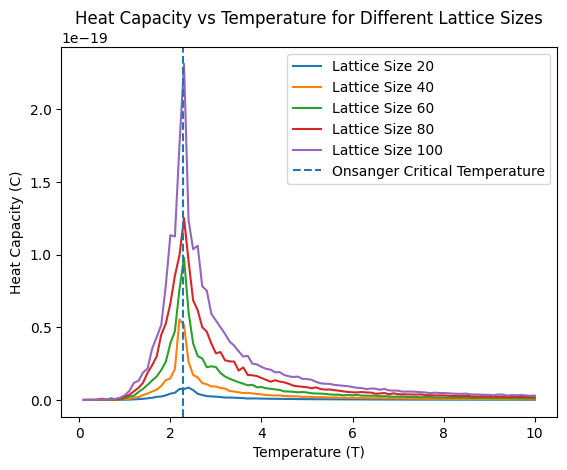

In [ ]:
@njit(parallel=True)
def monte_carlo_energy(lattice, neighbor_lattice, rand_vals, is_black, interaction_const, beta_val, beta_mu_H_val):
    """Perform a Monte Carlo step on the lattice and calculate energy.

    Parameters:
    - lattice (numpy.ndarray): The lattice to perform the step on.
    - neighbor_lattice (numpy.ndarray): The neighboring lattice.
    - rand_vals (numpy.ndarray): Random values used for Monte Carlo moves.
    - is_black (bool): True if the lattice is black, False otherwise.
    - interaction_const (float): Interaction constant (J).
    - beta_val (float): Inverse temperature (beta).
    - beta_mu_H_val (float): Dimensionless parameter for external magnetic field..

    Returns:
    - energy: The energy of the lattice prior to any flipping
    """
    n, m = lattice.shape
    energy = 0

    for i in prange(n):
        for j in prange(m):
            # Set stencil indices with periodicity
            ipp = (i + 1) if (i + 1) < n else 0
            jpp = (j + 1) if (j + 1) < m else 0
            inn = (i - 1) if (i - 1) >= 0 else (n - 1)
            jnn = (j - 1) if (j - 1) >= 0 else (m - 1)

            # Select off-column index based on color and row index parity
            if (is_black):
                joff = jpp if (i % 2) else jnn
            else:
                joff = jnn if (i % 2) else jpp

            # Compute sum of nearest neighbor spins
            nn_sum = neighbor_lattice[inn, j] + neighbor_lattice[i, j] + neighbor_lattice[ipp, j] + neighbor_lattice[i, joff]

            # Compute energy change
            spin_i = lattice[i, j]
            deltaE = -2 * spin_i * (interaction_const * nn_sum + beta_mu_H_val / beta_val)
            energy += -deltaE / 2  # Accumulate energy change

            if deltaE > 0:
                lattice[i, j] = -spin_i
            elif rand_vals[i, j] < np.exp(deltaE * beta_val):
                lattice[i, j] = -spin_i
    return energy

def calculate_heat_capacity(energy_var, T):
    """Calculate heat capacity using the fluctuation-dissipation theorem."""
    return energy_var / (boltz_const * (T ** 2))

def monte_carlo_simulation(lattice_size, temp_values, J):
    """Perform Monte Carlo simulation for a range of temperatures and lattice sizes."""
    heat_capacity_values = []

    for temp in temp_values:
      black_lattice = generate_spin_lattice(lattice_size, lattice_size // 2)  # m/2 array for black lattice
      white_lattice = generate_spin_lattice(lattice_size, lattice_size // 2)  # m/2 array for white lattice
      lattice = generate_spin_lattice(lattice_size, lattice_size // 2)
      energy_values1 = []
      energy_values2 = []

      for i in range(5000):
        rand_vals = generate_random_matrix(lattice_size, lattice_size // 2)
        monte_carlo_step(black_lattice, white_lattice, rand_vals, True, J, 1/(boltz_const*temp), 0)

        rand_vals = generate_random_matrix(lattice_size, lattice_size // 2)
        monte_carlo_step(white_lattice, black_lattice, rand_vals, False, J, 1/(boltz_const*temp), 0)

        lattice = merge_lattices(black_lattice, white_lattice, lattice_size, lattice_size)

      for _ in range(500):
        rand_vals = generate_random_matrix(lattice_size, lattice_size // 2)
        energy_values1.append(monte_carlo_energy(black_lattice, white_lattice, rand_vals, True, J, 1/(boltz_const*temp), 0))

        rand_vals = generate_random_matrix(lattice_size, lattice_size // 2)
        energy_values2.append(monte_carlo_energy(white_lattice, black_lattice, rand_vals, False, J, 1/(boltz_const*temp), 0))

      energy_values = energy_values1 + energy_values2
      energy_var = np.var(energy_values)
      heat_capacity = calculate_heat_capacity(energy_var, temp)
      heat_capacity_values.append(heat_capacity)

    return heat_capacity_values

heat_capacity_results = []

lattice_sizes = [20, 40, 60, 80, 100]  # different lattice sizes
temp_values = np.linspace(0.1, 10, 100)  # temperature range

for lattice_size in lattice_sizes:
    heat_capacity_results.append(monte_carlo_simulation(lattice_size, temp_values, boltz_const)) # I have chosen J = 1 * boltzmann constant

######### PLOTTING #############
for i, lattice_size in enumerate(lattice_sizes):
    plt.plot(temp_values, heat_capacity_results[i], label=f'Lattice Size {lattice_size}')

plt.xlabel('Temperature (T)')
plt.ylabel('Heat Capacity (C)')
critical_temperature = 2 / (np.log(1+(2)**(1/2))) # Onsanger critical temperature when J = k_B
plt.axvline(x=critical_temperature, label = 'Onsanger Critical Temperature', linestyle='--')
plt.title('Heat Capacity vs Temperature for Different Lattice Sizes')
plt.legend()
plt.show()

**Supplementary Task: investigate the heat capacity near the phase transition SUMMARY**

I notice that there is a peak in the heat capacity near the phase transition point / Onsanger temperature. Moreover, as you increase the lattice size, this peak appears to become taller and narrower. This is understandable as the greater the lattice size, the closer the lattice is to the infinite lattice size considered by Onsanger.